<a href="https://colab.research.google.com/github/MarlonGrandy/LSTMMusicGeneration/blob/main/LSTMMusicGenerationPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is recommended to run this file using Google Collab. We ran into issue with the music conversion on out local machines but had not issues on Google Collab. 
We also ran into many issues with RAM on Collab. If the file does not run all the way through, you can remove songs from the midi song's file and run it again. 

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import statements
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, duration
import glob
import os
from itertools import chain
import copy
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import CuDNNLSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from numpy import argmax
from fractions import Fraction
import gc
import random
import keras.utils

In [ ]:
def data_extractor(directory):
  """
    Summary:
    Function converts midi files to metadata and appends nested metadata lists into one large list
    composed of all the songs in the dataset.

    Parameters:
    directory: String representation of directory where midi files are located

    Returns:
    list: sequential midi file metadata 
   """
  notes = []
  offsets = []
  durations = []
  for file in glob.glob(directory):
          mid = converter.parse(file)
          notes_to_parse = None
          prev_offset = 0
          
          try: 
              s2 = instrument.partitionByInstrument(mid)
              notes_to_parse = s2.parts[0].recurse() 
              
          except: 
              notes_to_parse = mid.flat.notes

          for i,element in enumerate(notes_to_parse):
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))
                  
                  durations.append(str(element.quarterLength))
                  
                  offset_dif = float(element.offset-prev_offset)
              
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset
             
                 
              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))
                  offset_dif = float(element.offset-prev_offset)

                  durations.append(str(element.quarterLength))
                  
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset

  return [notes,offsets,durations]

In [ ]:
#reading in data
data = data_extractor("/content/drive/MyDrive/midi_stuff/*.mid")
note_data = data[0]
offset_data = data[1]
duration_data = data[2]
#creating variables for unique data and unique data lengths
unique_note_number = len(list(set(note_data)))
unique_notes = sorted(list(set(note_data)))
unique_offset_number = len(list(set(offset_data)))
unique_offsets = sorted(list(set(offset_data)))
unique_duration_number = len(list(set(duration_data)))
unique_durations = sorted(list(set(duration_data)))

In [ ]:
def one_hot_encode(vector, all_values):
  """
  Summary:
  Function one hot encodes data.

  Parameters:
  vector: array to one hot encode
  all_values: array set of the vector parameter

  Returns:
  list: one hot encoded data
  """
  encoded_vectors = []
  int_to_index = dict((c, i) for i, c in enumerate(all_values))
  for i in vector:
    zero = [0]*(len(all_values)-1)
    zero.insert(int_to_index[i],1)
    encoded_vectors.append(zero)
  
  return encoded_vectors

In [ ]:
def one_hot_decode(vector,all_values):
  """
  Summary:
  Function one hot decodes the encoded data.

  Parameters:
  vector: array to one hot decode
  all_values: array set of the vector parameter

  Returns:
  list: one hot decoded data
  """
  decoded_vector = []
  index_to_int = dict((i, c) for i, c in enumerate(all_values))
  decoded_vector.append(index_to_int[argmax(vector)])
  return decoded_vector

In [ ]:
segment_length = 64
def make_segments(data_array,unique_values, seq_length = segment_length):
  """
  Summary:
  Splits data into segements with length segment_length

  Parameters:
  data_array: data to split into segments
  unique_values: array set of the data_array parameter
  seq_length: length of each sequence

  Returns:
  array tuple: array[0] = input data, array[1] = output data
  """
  input_seq = []
  output_seq = []

  processed_data = one_hot_encode(data_array,unique_values)
  
  for i in range(0,len(processed_data) - seq_length,1):
    input_seq.append([processed_data[i:i+seq_length]])
    output_seq.append(processed_data[seq_length + i])

  del processed_data;gc.collect()
  
  input_seq = np.reshape(input_seq,(len(input_seq), segment_length,len(unique_values)))
  output_seq = np.array(output_seq)

  return input_seq, output_seq

In [ ]:
#making segments for notes, offsets, and durations and garabge collecting unused varaibles to get RAM back
note_model_data = make_segments(data_array = note_data, unique_values = unique_notes)
del note_data
gc.collect()
offset_model_data = make_segments(data_array = offset_data, unique_values = unique_offsets)
del offset_data
gc.collect()
duration_model_data = make_segments(data_array = duration_data, unique_values = unique_durations)
del duration_data
gc.collect()

0

In [ ]:
#splitting notes, offsets, and durations into training and testing data
X_train_note, X_test_note, y_train_note, y_test_note = train_test_split(note_model_data[0], note_model_data[1],test_size=0.2)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(offset_model_data[0], offset_model_data[1],test_size=0.2)
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(duration_model_data[0], duration_model_data[1],test_size=0.2)

In [ ]:
#garabage collecting unused variables
del note_model_data
del offset_model_data
del duration_model_data
gc.collect()

0

In [ ]:
def make_model(input_shape,output_shape):
  """
  Summary:
  Defines and compiles the LSTM model

  Parameters:
  input_shape: LSTM input shape
  output_shape: LSTM output nshape

  Returns:
  Keras Model: Compiled Model
  """
  model = Sequential()
  model.add(CuDNNLSTM(512,input_shape=input_shape,return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(128))
  model.add(Dense(output_shape,activation = 'softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate = .001),
      metrics=['accuracy']
  )
  return model

In [ ]:
#makes note, offset, and duration model objects
model_notes = make_model(input_shape = (segment_length,unique_note_number), output_shape = unique_note_number)
model_offsets = make_model(input_shape = (segment_length,unique_offset_number), output_shape = unique_offset_number)
model_durations = make_model(input_shape = (segment_length,unique_duration_number), output_shape = unique_duration_number)

In [ ]:
#defines callabcks for training
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=4)]

In [ ]:
#fits the note model to train data
history_note = model_notes.fit(X_train_note,y_train_note,epochs=150, validation_split = 0.2, callbacks = my_callbacks)

Epoch 1/150
865/865 [==============================] - 20s 15ms/step - loss: 4.4585 - accuracy: 0.0447 - val_loss: 4.1126 - val_accuracy: 0.0701
Epoch 2/150
865/865 [==============================] - 12s 13ms/step - loss: 3.8747 - accuracy: 0.1081 - val_loss: 3.6731 - val_accuracy: 0.1425
Epoch 3/150
865/865 [==============================] - 12s 14ms/step - loss: 3.5376 - accuracy: 0.1565 - val_loss: 3.4427 - val_accuracy: 0.1722
Epoch 4/150
865/865 [==============================] - 12s 14ms/step - loss: 3.3428 - accuracy: 0.1910 - val_loss: 3.2553 - val_accuracy: 0.2092
Epoch 5/150
865/865 [==============================] - 12s 14ms/step - loss: 3.0944 - accuracy: 0.2312 - val_loss: 3.1185 - val_accuracy: 0.2314
Epoch 6/150
865/865 [==============================] - 12s 14ms/step - loss: 2.8972 - accuracy: 0.2631 - val_loss: 2.9827 - val_accuracy: 0.2696
Epoch 7/150
865/865 [==============================] - 12s 14ms/step - loss: 2.6865 - accuracy: 0.3103 - val_loss: 2.8758 - val_ac

In [ ]:
#fits the offset model to train data
history_offset = model_offsets.fit(X_train_off,y_train_off,epochs=150, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/150
865/865 [==============================] - 10s 11ms/step - loss: 1.1275 - accuracy: 0.5724 - val_loss: 0.9757 - val_accuracy: 0.6236
Epoch 2/150
865/865 [==============================] - 9s 11ms/step - loss: 0.8929 - accuracy: 0.6693 - val_loss: 0.8332 - val_accuracy: 0.7018
Epoch 3/150
865/865 [==============================] - 9s 11ms/step - loss: 0.8021 - accuracy: 0.7088 - val_loss: 0.7710 - val_accuracy: 0.7249
Epoch 4/150
865/865 [==============================] - 9s 11ms/step - loss: 0.7461 - accuracy: 0.7288 - val_loss: 0.7367 - val_accuracy: 0.7258
Epoch 5/150
865/865 [==============================] - 9s 11ms/step - loss: 0.7075 - accuracy: 0.7457 - val_loss: 0.7151 - val_accuracy: 0.7415
Epoch 6/150
865/865 [==============================] - 9s 11ms/step - loss: 0.6755 - accuracy: 0.7593 - val_loss: 0.6746 - val_accuracy: 0.7546
Epoch 7/150
865/865 [==============================] - 9s 11ms/step - loss: 0.6404 - accuracy: 0.7732 - val_loss: 0.6769 - val_accuracy

In [ ]:
#fits the duration model to train data
history_duration = model_durations.fit(X_train_dur,y_train_dur,epochs=150, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/150
865/865 [==============================] - 11s 11ms/step - loss: 1.2716 - accuracy: 0.6059 - val_loss: 1.1619 - val_accuracy: 0.6240
Epoch 2/150
865/865 [==============================] - 9s 11ms/step - loss: 1.1687 - accuracy: 0.6231 - val_loss: 1.1020 - val_accuracy: 0.6367
Epoch 3/150
865/865 [==============================] - 9s 11ms/step - loss: 1.1140 - accuracy: 0.6437 - val_loss: 1.0728 - val_accuracy: 0.6597
Epoch 4/150
865/865 [==============================] - 9s 11ms/step - loss: 1.0700 - accuracy: 0.6589 - val_loss: 1.0331 - val_accuracy: 0.6677
Epoch 5/150
865/865 [==============================] - 9s 11ms/step - loss: 1.0296 - accuracy: 0.6737 - val_loss: 0.9841 - val_accuracy: 0.6816
Epoch 6/150
865/865 [==============================] - 9s 11ms/step - loss: 0.9840 - accuracy: 0.6894 - val_loss: 0.9534 - val_accuracy: 0.6930
Epoch 7/150
865/865 [==============================] - 9s 11ms/step - loss: 0.9345 - accuracy: 0.7060 - val_loss: 0.9066 - val_accuracy

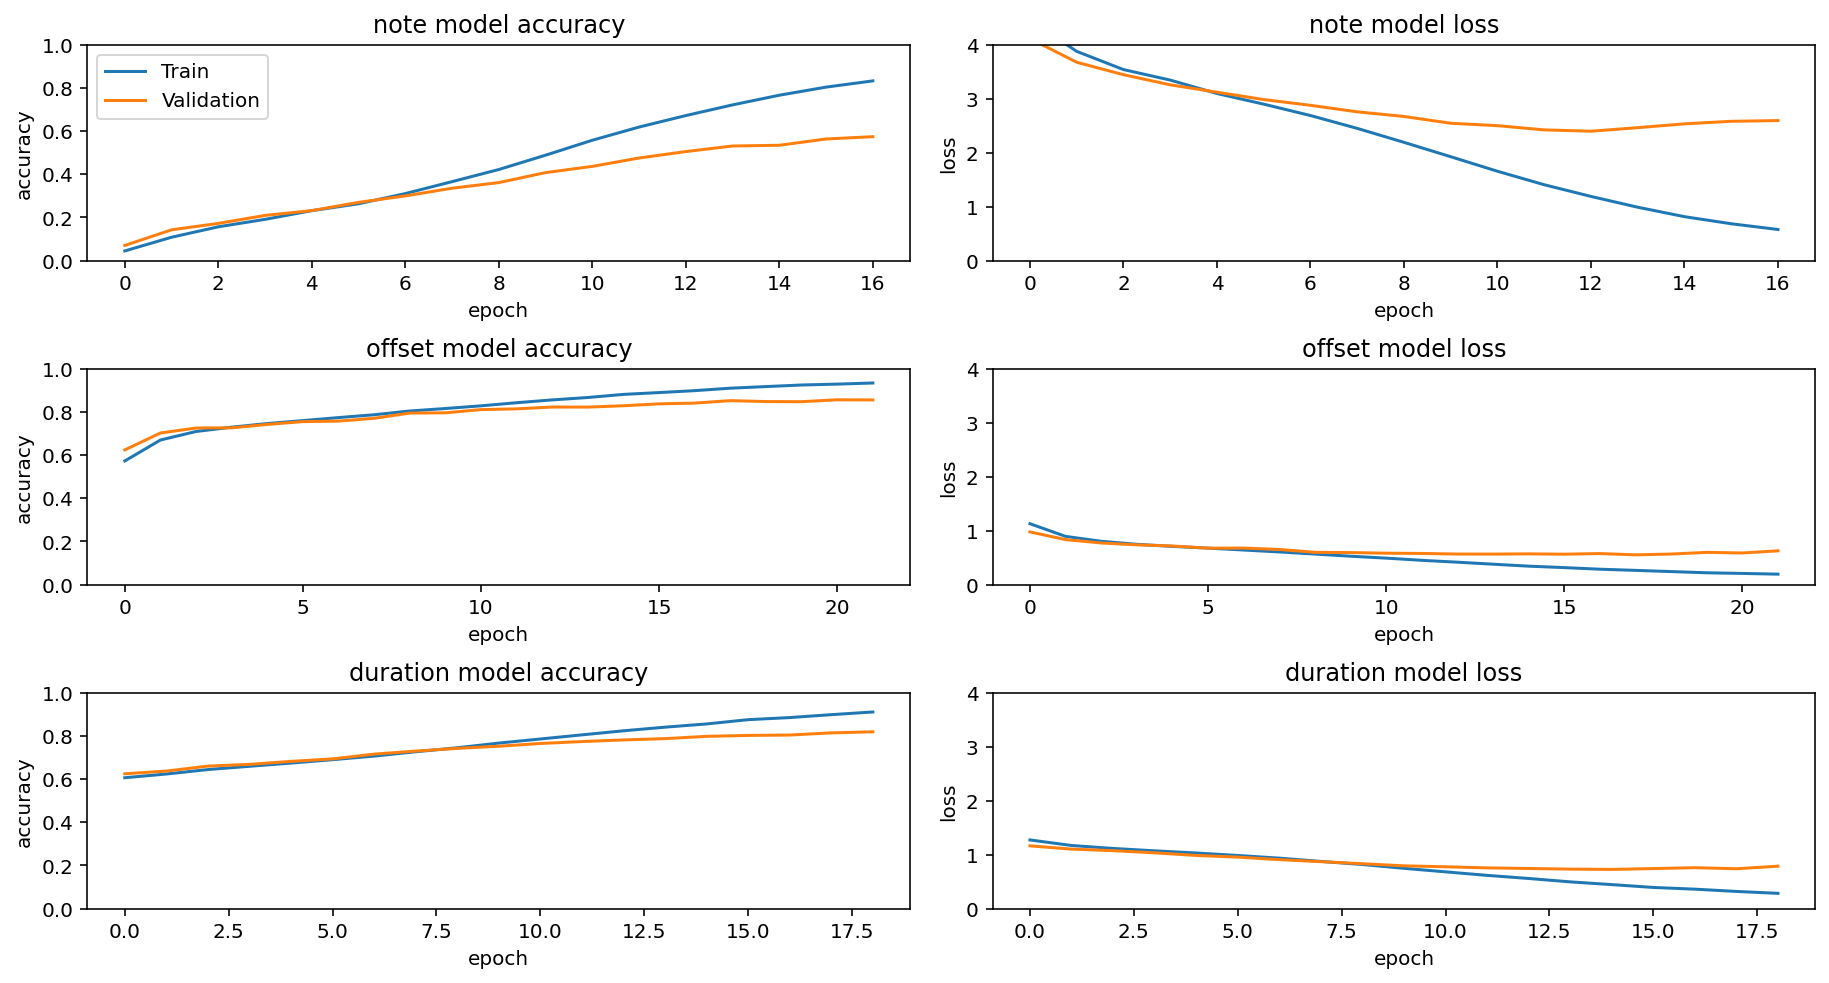

In [ ]:
#plotting model results
plt.subplot(3,2,1)
plt.plot(history_note.history['accuracy']);plt.plot(history_note.history['val_accuracy']);plt.title('note model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.legend(['Train', 'Validation'], loc='upper left');plt.ylim(0,1)
plt.subplot(3,2,2)
plt.plot(history_note.history['loss']);plt.plot(history_note.history['val_loss']);plt.title('note model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,3)
plt.plot(history_offset.history['accuracy']);plt.plot(history_offset.history['val_accuracy']);plt.title('offset model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,4)
plt.plot(history_offset.history['loss']);plt.plot(history_offset.history['val_loss']);plt.title('offset model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,5)
plt.plot(history_duration.history['accuracy']);plt.plot(history_duration.history['val_accuracy']);plt.title('duration model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,6)
plt.plot(history_duration.history['loss']);plt.plot(history_duration.history['val_loss']);plt.title('duration model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplots_adjust(left=0, 
                    bottom=0,  
                    right=2.0,  
                    top=1.5,  
                    wspace=0.1,  
                    hspace=0.5)


In [ ]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  
    preds = preds / np.sum(preds)                
    probas = np.random.multinomial(1, preds, 1)  
    return np.argmax(probas)                     

In [ ]:
def music_maker(seed_vec, model_type, number_unique, unique, diversity, num_notes = 100):
  """
  Summary:
  Generates new data from seed

  Parameters:
  seed_vec: random seed from the training data
  model_type: model object correspodning to type of seed_vec (note, offset, or durration)
  number_unique: number of unique notes in seed_vec
  unique: unique notes in seed_vec
  diversity: diversity (temperature) value
  num)_notes: number of new notes to generate

  Returns:
  list: generated data
  """
  music = []
  arr = np.zeros((len(seed_vec)+num_notes,number_unique))
  for c,i in enumerate(seed_vec):
    arr[c] = i

  for i in range(0,num_notes,1):
    d_arr = np.zeros(number_unique)
    pred = model_type.predict(np.reshape(arr[i:len(arr)-num_notes+i], (1, len(arr[i:len(arr)-num_notes+i]),number_unique)),verbose = 0)[0]
    diverse = sample(pred, diversity)
    d_arr[diverse] = 1
    music.append(one_hot_decode(d_arr,all_values = unique)[0])

    arr[len(seed_vec)+i] = d_arr
  
  return music

In [ ]:
#samples a random numebr from the testing data to use as a seed and generates new data based on the seed
randnum = random.randrange(0,len(X_test_note))
test_note = X_test_note[randnum]
test_offset = X_test_off[randnum]
test_dur = X_test_dur[randnum]
generated_music_note = music_maker(test_note, model_notes, unique_note_number, unique_notes, 0.7)
generated_music_offset = music_maker(test_offset,model_offsets,unique_offset_number, unique_offsets, 0.7)
generated_music_duration = music_maker(test_dur, model_durations, unique_duration_number, unique_durations, 0.2)

In [ ]:
#converts the seed back to the original midi metadata
seed_notes = []
seed_offsets = []
seed_durations = []
for n in test_note:
  seed_notes.append(one_hot_decode(n ,unique_notes)[0]) 
for o in test_offset:
  seed_offsets.append(one_hot_decode(o ,unique_offsets)[0]) 
for d in test_dur:
  seed_durations.append(one_hot_decode(d, unique_durations)[0])

In [ ]:
def to_midi(notes, offsets, durations):
  """
  Summary:
  Takes midi metadata and converts it to a Music21 stream. The stream can then easily be converted into a midi file.

  Parameters:
  notes: note metadata
  offsets: offset metadata
  durations: durations metadata

  Returns:
  Music21 stream object
  """
  offset = offsets[0]
  s = stream.Stream()
  for i,ele in enumerate(notes):
    if ele[0].isalpha():
      n = note.Note(ele)
      try:
        n.quarterLength = float(durations[i])
      except:
        n.quarterLength = Fraction(durations[i])

      s.insert(offset,n)

      offset += offsets[i]
    else:
      chords = list(map(int,ele.split('.')))
      c = chord.Chord(chords)

      try:
        c.quarterLength = float(durations[i])
      except:
        c.quarterLength = Fraction(durations[i])

      s.insert(offset,c)

      offset += offsets[i]
  return s

In [ ]:
#converts the generated music to a midi file
to_midi(generated_music_note,generated_music_offset, generated_music_duration).write('midi', "generated_classical_final.mid")
#converts the seed to a midi file
to_midi(seed_notes,seed_offsets,seed_durations).write('midi', "seed_classical_final.mid")


'seed_classical_final.mid'